In [1]:
import pandas as pd
import mne
import numpy as np
import autoreject
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy
import sklearn

from mna.sessions.eye_session import process_session_eye
from mna.sessions.eeg_session import process_session_eeg
from mna.sessions.motor_session import process_session_motor
from mna.sessions.ecg_session import process_session_ecg

# 1. Read a RN App, converted pkl file, and create the metadata and data structure

In [2]:
from os import listdir
from os.path import isfile, join
from mna.utils.rnapp_data_format import read_all_lslpresets, return_metadata_from_name, event_data_from_data
import pickle

In [3]:
data_dir = "../data/"
lsl_dir = "../mna/LSLPresets/"
onlyfiles = [f for f in listdir(data_dir) if isfile(join(data_dir, f)) and '.pkl' in f]
input_path = data_dir + onlyfiles[-1] # pick a random file
print(f"input_path {input_path}")
metadata_jsons = read_all_lslpresets(path_to_jsonfiles=lsl_dir)
with open(input_path, 'rb') as handle:
    rns_data = pickle.load(handle)

## Add metadata to data

for key in rns_data.keys():
    rns_data[key].append(return_metadata_from_name(key, metadata_jsons))

input_path ../data/06_15_2022_10_38_35-Exp_myexperiment-Sbj_02-Ssn_02.dats.pkl


# 2. Create new events (trial start etc.)

In [4]:
event_df = event_data_from_data(rns_data)
event_df['trial_damage'] = event_df.damage.diff().fillna(0)
event_df['trial_duration'] = event_df.trial_end_time - event_df.trial_start_time
percent_missing = event_df.notnull().sum() / len(event_df)
summary_statistics = {}
summary_statistics['voice_success_rate'] = percent_missing['voice_timestamp']
if 'chunk_timestamp' in percent_missing:
    summary_statistics['chunk_success_rate'] = percent_missing['chunk_timestamp']
else:
    summary_statistics['chunk_success_rate'] = 0

# temporary fix for pilot phase where we had some incomplete data
if 'block_condition' not in event_df:
    event_df['block_condition'] = 'practice'
    event_df.loc[5:,'block_condition'] = 'voice'

event_df['spoken_difficulty_encoded'] = event_df.spoken_difficulty.replace(to_replace=['easy', 'hard', 'unknown'],
                                                                      value=[1, 2, None])

## Pupil Diameter Extraction

In [5]:
eye_channel='Unity_ViveSREyeTracking'
df_eye = pd.DataFrame(rns_data[eye_channel][0], columns=rns_data[eye_channel][1],
                      index=rns_data[eye_channel][2]['ChannelNames']).T

n_samples = rns_data[eye_channel][2]['NominalSamplingRate']*6

label = np.empty(len(event_df.index)-1)
trials_left_pupil = np.empty([len(event_df.index)-1, n_samples])
trials_right_pupil = np.empty([len(event_df.index)-1, n_samples])

#Skip last trial because it's empty
for i in range(len(event_df.index)-1):
    L_Pupil_Diameter = np.asarray(df_eye['L Pupil Diameter'][(df_eye.index >= event_df['trial_start_time'][i]) &
                                         (df_eye.index <= event_df['trial_end_time'][i]) &
                                                   (df_eye['L Pupil Diameter'] > -1)].replace(-1, np.nan))
    trials_left_pupil[i, :] = L_Pupil_Diameter[:n_samples]

    R_Pupil_Diameter = np.asarray(df_eye['R Pupil Diameter'][(df_eye.index >= event_df['trial_start_time'][i]) &
                                         (df_eye.index <= event_df['trial_end_time'][i]) &
                                                   (df_eye['R Pupil Diameter'] > -1)].replace(-1, np.nan))
    trials_right_pupil[i, :] = R_Pupil_Diameter[:n_samples]

    label[i] = event_df.spoken_difficulty_encoded[i]

trials_left_pupil = trials_left_pupil[pd.isna(label)==False]
trials_right_pupil = trials_right_pupil[pd.isna(label)==False]
label = label[pd.isna(label)==False].astype(int)

## Artifact Removal

In [6]:
eeg_montage = 'biosemi64'
eeg_channel = 'BioSemi'
run_autoreject=True
autoreject_epochs=20
average_reference=True
low_cut=1.
hi_cut=50.
event_column='spoken_difficulty_encoded'

event_detected = event_df[event_column].notnull()
event_recognized_df = event_df[event_detected]

eeg_channel_names = mne.channels.make_standard_montage(eeg_montage).ch_names
df = pd.DataFrame(rns_data[eeg_channel][0], columns=rns_data[eeg_channel][1],
                  index=rns_data[eeg_channel][2]['ChannelNames']).T
starting_time_s = rns_data[eeg_channel][1][0]
freq = rns_data[eeg_channel][2]['NominalSamplingRate']
rna_channel_names = list(df.columns)
rna_channel_names[1:65] = eeg_channel_names
info = mne.create_info(ch_names=rna_channel_names, ch_types=['stim'] + ['eeg'] * 64 + ['ecg'] * 2 + ['misc'] * 22,
                       sfreq=freq)
info.set_montage(eeg_montage)

raw = mne.io.RawArray(df.T * 1e-6, info)
raw = raw.pick(['eeg','ecg'])
if average_reference:
    raw = raw.set_eeg_reference(ref_channels='average')  # set average reference
if low_cut or hi_cut:
    raw.filter(l_freq=low_cut, h_freq=hi_cut, verbose=False)

trial_start_time = event_recognized_df.trial_start_time - starting_time_s  # reference for mne
event_values = event_recognized_df[event_column].values
events = np.column_stack((trial_start_time.values * freq,
                          np.zeros(len(event_recognized_df), dtype=int),
                          event_values)).astype(int)
event_dict = dict(easy=1, hard=2)
epochs = mne.Epochs(raw, events, event_id=event_dict, baseline = (None, None), tmin=-3, tmax=0, preload=True, on_missing='warn')

event_recognized_df = event_recognized_df[[e==() for e in epochs.drop_log]] # only keep good epochs in event_df

#Autoreject
if len(epochs) < 10: # we need at least 10 epochs to run autoreject for cross validation
    bad_epochs = pd.Series(np.full(len(event_df),np.NAN), index=event_df.index, name='autorejected')
    event_df = event_df.join(bad_epochs)
    reject_log = None

elif run_autoreject:
    ar = autoreject.AutoReject(random_state=11, n_jobs=2, verbose=False)
    ar.fit(epochs[:autoreject_epochs])  # fit on a few epochs to save time
    epochs_ar, reject_log = ar.transform(epochs, return_log=True)
    bad_epochs = pd.Series(reject_log.bad_epochs, index=event_recognized_df.index, dtype=bool, name='autorejected')
    event_df = event_df.join(bad_epochs) # creates nan if not processed at all
    epochs = epochs_ar


Creating RawArray with float64 data, n_channels=89, n_times=2725394
    Range : 0 ... 2725393 =      0.000 ...  1330.758 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
48 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 6145 original time points ...
0 bad epochs dropped


In [7]:
# epoch_concat_np = np.empty([66,epochs.get_data().shape[0]*epochs.get_data().shape[2]])
#
# for i in range(len(epochs.get_data())):
#     epoch_concat_np[:,i*epochs.get_data().shape[2]:epochs.get_data().shape[2]*(i+1)] = epochs.get_data()[i]

In [34]:
ica = mne.preprocessing.ICA(n_components=.95, random_state=64)
ica.fit(epochs)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by explained variance: 16 components
Fitting ICA took 15.6s.


Method,fastica
Fit,42 iterations on epochs (294960 samples)
ICA components,16
Explained variance,95.3 %
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Opening ica-browser...


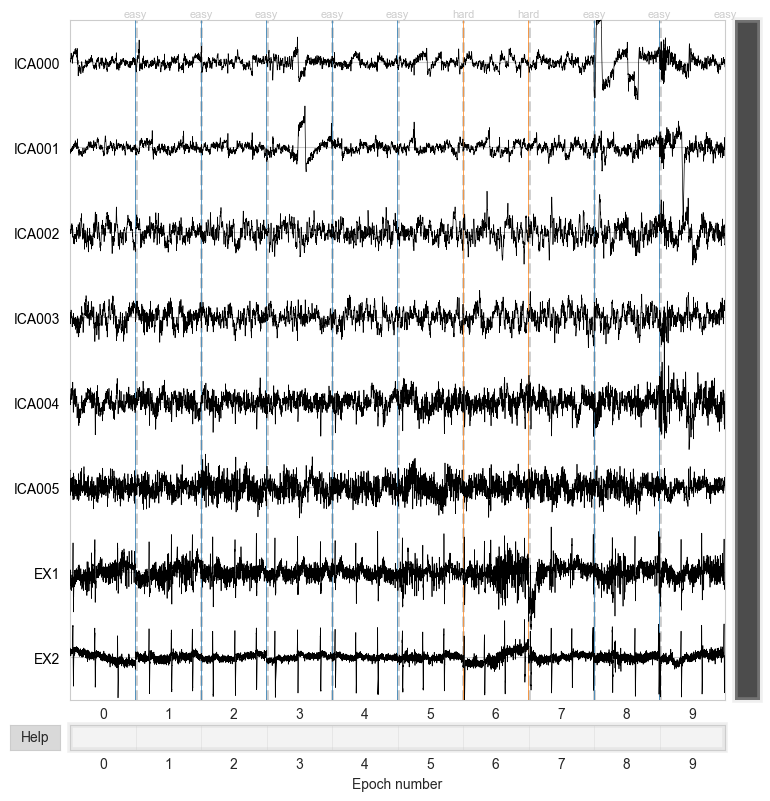

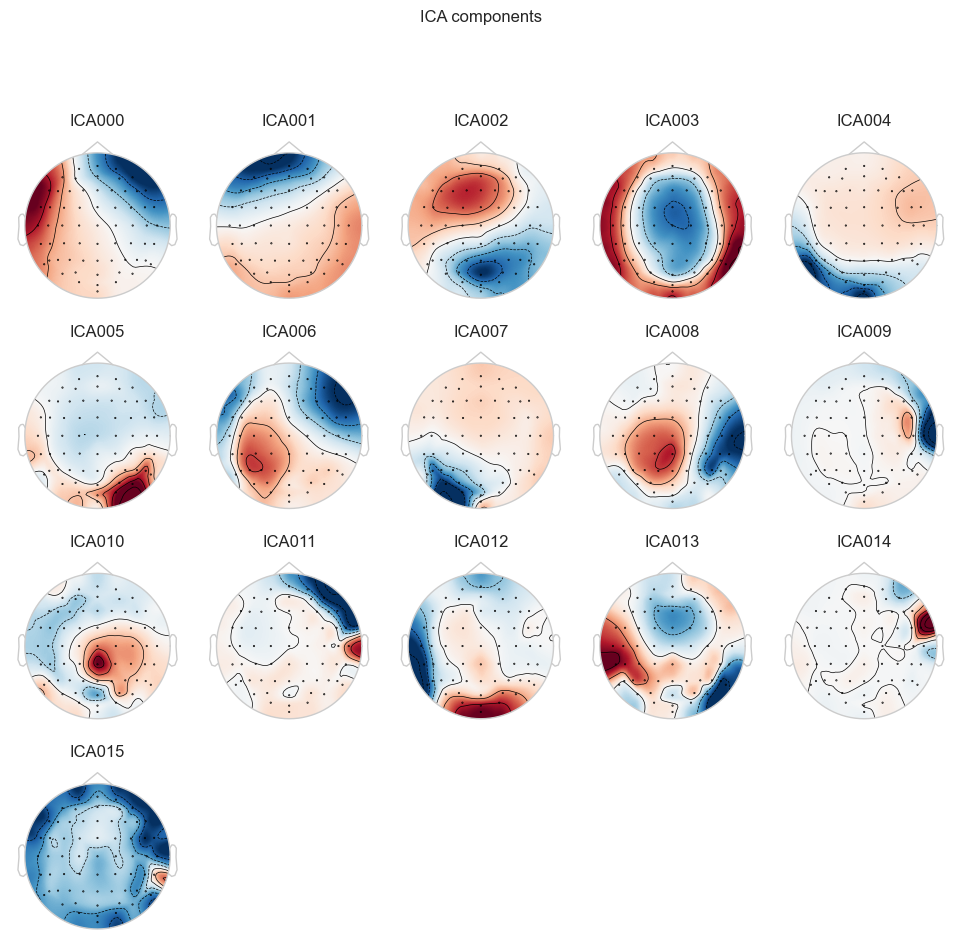

[<MNEFigure size 975x967 with 16 Axes>]

In [37]:
ica.plot_sources(epochs[:10], picks=[0,1,2,3,4,5])
ica.plot_components()

In [39]:
# Artifact Detection
eog_idx, eog_scores = ica.find_bads_eog(epochs, ch_name = ['Fpz'])
ecg_idx, ecg_scores = ica.find_bads_ecg(epochs, method='ctps', measure='correlation', threshold="auto")
muscle_idx, muscle_scores = ica.find_bads_muscle(raw)

print([eog_idx, ecg_idx, muscle_idx])

# ica.plot_scores(eog_scores, exclude=eog_idx)
# ica.plot_scores(ecg_scores, exclude=ecg_idx)
# ica.plot_scores(muscle_scores, exclude=muscle_idx)

# first half all non-ECG component (EOG component was identified as ECG component as well). second half eog component
non_ECG_comp = list(set(np.arange(ica.n_components_)).symmetric_difference(set(ecg_idx))) + \
               list(set(ecg_idx).intersection(set(eog_idx)))

Using EOG channel: Fpz
Using threshold: 0.12 for CTPS ECG detection
Effective window size : 0.125 (s)


In [ ]:
# Identified Artifact Component Removal
eeg_data_ICA = epochs.copy()
# ica.apply(eeg_data_ICA, exclude=eog_idx+ecg_idx+muscle_idx)
# ica.apply(eeg_data_ICA, exclude=eog_idx+ecg_idx)
ica.apply(eeg_data_ICA, exclude=eog_idx)
# ica.apply(eeg_data_ICA, exclude=non_ECG_comp)

In [10]:
# plot before and after component removal signal
# epochs.plot(n_channels=10, n_epochs=5, show_scrollbars=False)
# eeg_data_ICA.plot(n_channels=10, n_epochs=5, show_scrollbars=False)

## Trial Difficulty Classification

In [42]:
from sklearn.model_selection import train_test_split
from mne_features.univariate import compute_hjorth_mobility,compute_pow_freq_bands

# Dataset Split - EEG
x_train_raw, x_test_raw, y_train_raw, y_test_raw = train_test_split(epochs.get_data()[:,:64,:], epochs.events[:,2], random_state=64, test_size=10)
x_train_AR, x_test_AR, y_train_AR, y_test_AR = train_test_split(eeg_data_ICA.get_data()[:,:64,:], eeg_data_ICA.events[:,2],
                                                                    random_state=64, test_size=10)

# Dataset Split - Pupil Diameter
x_train_pupil, x_test_pupil, y_train_pupil, y_test_pupil = train_test_split(trials_left_pupil, label, random_state=64, test_size=10)

# Feature extraction
def eeg_feature(train_raw, test_raw, train_ar, test_ar, method, band_intervals = None):

    if method == 'psd':

        band_freq = band_intervals

        train_feature_raw = np.empty([len(train_raw), len(eeg_channel_names)*(len(band_freq)-1)])
        test_feature_raw = np.empty([len(test_raw), len(eeg_channel_names)*(len(band_freq)-1)])
        train_feature_ar = np.empty([len(train_ar), len(eeg_channel_names)*(len(band_freq)-1)])
        test_feature_ar = np.empty([len(test_ar), len(eeg_channel_names)*(len(band_freq)-1)])

        for i in range(len(train_raw)):

            train_feature_raw[i,:] = compute_pow_freq_bands(freq, train_raw[i], freq_bands = band_freq)
            train_feature_ar[i,:] = compute_pow_freq_bands(freq, train_ar[i], freq_bands = band_freq)

        for j in range(len(test_raw)):
            test_feature_raw[j,:] = compute_pow_freq_bands(freq, test_raw[j], freq_bands = band_freq)
            test_feature_ar[j,:] = compute_pow_freq_bands(freq, test_ar[j], freq_bands = band_freq)

    if method == 'hjorth_mobility':
        train_feature_raw = compute_hjorth_mobility(train_raw)
        test_feature_raw = compute_hjorth_mobility(test_raw)

        train_feature_ar = compute_hjorth_mobility(train_ar)
        test_feature_ar = compute_hjorth_mobility(test_ar)

    if method == "temporal_avg":
        train_feature_raw = np.mean(x_train_AR, axis = -1)
        test_feature_raw = np.mean(x_test_AR, axis = -1)

        train_feature_ar = np.mean(x_train_raw, axis = -1)
        test_feature_ar = np.mean(x_test_raw, axis = -1)

    return train_feature_raw, test_feature_raw, train_feature_ar, test_feature_ar

# call function for eeg feature extraction
raw_train_feature, raw_test_feature, AR_train_feature, AR_test_feature = eeg_feature(x_train_raw, x_test_raw, x_train_AR, x_test_AR, 'psd', band_intervals = np.array([3,8,13,30,64]))

In [43]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns

# Trial Difficulty Classification Function
def spoken_difficulty_classification(train_data, test_data, train_label, test_label, method):

    if method == 'logistic':

        logreg = LogisticRegression(solver="liblinear", random_state=0).fit(train_data, train_label)
        score_train = logreg.decision_function(train_data)
        score_test = logreg.decision_function(test_data)

        train_pred = logreg.predict(train_data)
        test_pred = logreg.predict(test_data)

    if method == 'svm':

        svm_classifer = SGDClassifier(random_state=0).fit(train_data, train_label)
        score_train = svm_classifer.decision_function(train_data)
        score_test = svm_classifer.decision_function(test_data)

        train_pred = svm_classifer.predict(train_data)
        test_pred = svm_classifer.predict(test_data)

    if method == 'knn':
        kNN = KNeighborsClassifier(n_neighbors = 3).fit(train_data, train_label)

        score_train = kNN.predict_proba(train_data)[:,1]
        score_test = kNN.predict_proba(test_data)[:,1]

        train_pred = (score_train > 0.5) + 0
        test_pred = (score_test >0.5) + 0

    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(train_label-1, score_train)
    ROC_score_train = metrics.roc_auc_score (train_label-1, score_train)

    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(test_label-1, score_test)
    ROC_score_test = metrics.roc_auc_score (test_label-1, score_test)

    train_acc = metrics.accuracy_score(train_label,train_pred)
    test_acc = metrics.accuracy_score(test_label,test_pred)

    # ROC Curve
    fig = plt.figure(figsize = [10 ,3])

    axe = fig.add_subplot(1,2,1)
    axe.plot(fpr_train,tpr_train)
    axe.set_xlabel("False Positive Rate")
    axe.set_ylabel("True Positive Rate")
    axe.set_title("Training ROC Curve")
    axe.text(0.6,0.2,"ROC Score = {:.2f}".format(ROC_score_train))

    axe = fig.add_subplot(1,2,2)
    axe.plot(fpr_test,tpr_test)
    axe.set_xlabel("False Positive Rate")
    axe.set_ylabel("True Positive Rate")
    axe.set_title("Testing ROC Curve")
    axe.text(0.6,0.2,"ROC Score = {:.2f}".format(ROC_score_test))

    # plt.grid(visible=False)
    # Confusion Matrix
    # fig, (ax1, ax2) = plt.subplots(1,2)
    fig_cnf = plt.figure(figsize = [10 ,3])
    ax1 = fig_cnf.add_subplot(1,2,1)
    ax2 = fig_cnf.add_subplot(1,2,2)

    cnf_matrix_train = metrics.confusion_matrix(train_label, train_pred)
    cnf_matrix_test = metrics.confusion_matrix(test_label, test_pred)

    sns.heatmap(cnf_matrix_train, annot = True, xticklabels = ['Easy','Hard'], yticklabels = ['Easy','Hard'],ax=ax1)
    ax1.set_title("Training Confusion Matrix")
    sns.heatmap(cnf_matrix_test, annot = True, xticklabels = ['Easy','Hard'], yticklabels = ['Easy','Hard'],ax=ax2)
    ax2.set_title("Testing Confusion Matrix")
    plt.show()

    return test_pred, train_pred, train_acc, test_acc

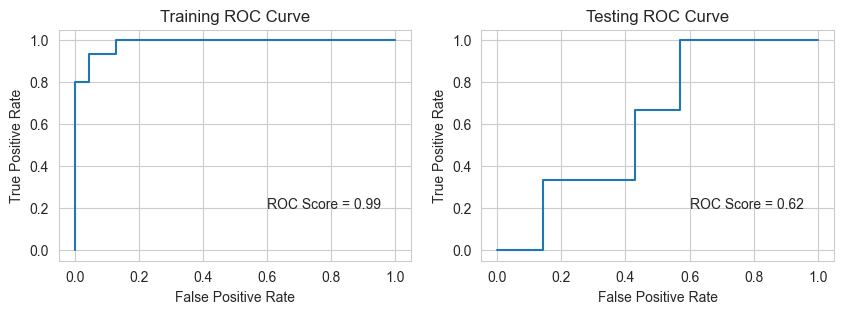

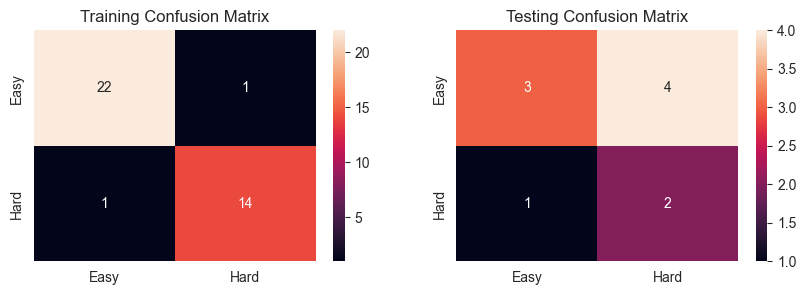

In [44]:
# Trial Difficulty Classification - Pupil Diameter
test_pred_raw, train_pred_raw, train_acc_raw, test_acc_raw = spoken_difficulty_classification(x_train_pupil, x_test_pupil,y_train_pupil, y_test_pupil, 'logistic')

# print(f"Training Accuracy with Pupil Diameter: {train_acc_raw:.2f} \n"
#       f"Train Label:      {y_train_raw} \n"
#       f"Train Prediction: {train_pred_raw} \n"
#       f"Test Accuracy with Pupil Diameter: {test_acc_raw:.2f} \n"
#       f"Test Label:      {y_test_raw} \n"
#       f"Test Prediction: {test_pred_raw}\n")

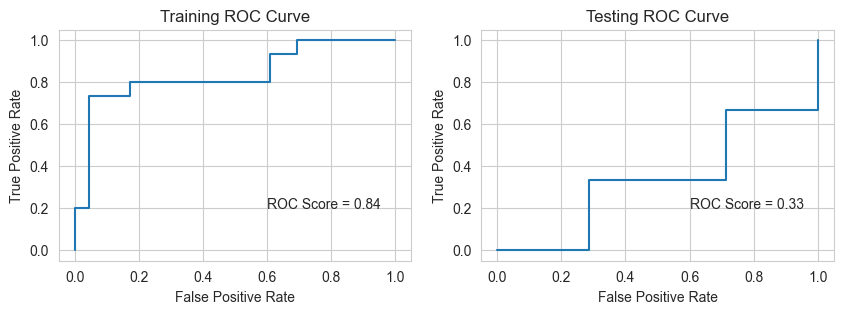

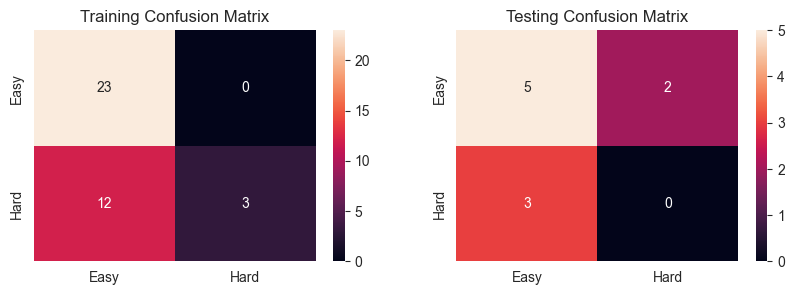

In [45]:
# Trial Difficulty Classification - Raw EEG
test_pred_raw, train_pred_raw, train_acc_raw, test_acc_raw = spoken_difficulty_classification(raw_train_feature, raw_test_feature,y_train_raw, y_test_raw, 'logistic')

# print(f"Training Accuracy without Artifacts Removal: {train_acc_raw:.2f} \n"
#       f"Train Label:      {y_train_raw} \n"
#       f"Train Prediction: {train_pred_raw} \n"
#       f"Test Accuracy without Artifacts Removal: {test_acc_raw:.2f} \n"
#       f"Test Label:      {y_test_raw} \n"
#       f"Test Prediction: {test_pred_raw}\n")

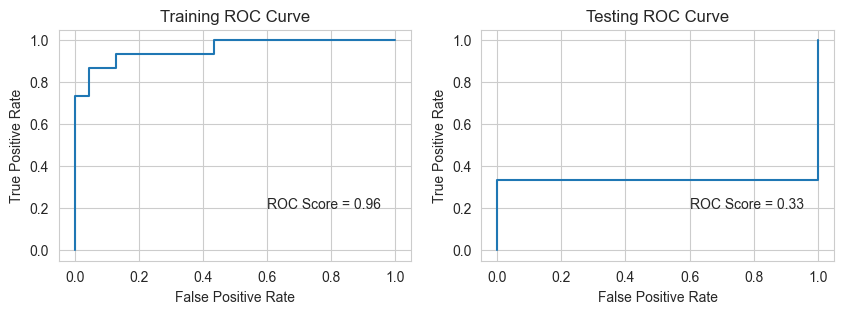

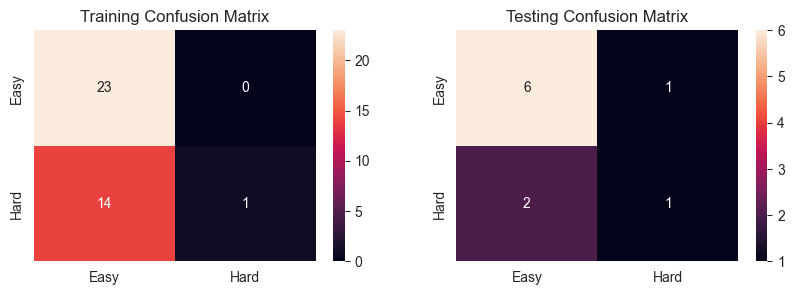

In [46]:
# Trial Difficulty Classification - Artifacts Removed EEG

test_pred_AR, train_pred_AR, train_acc_AR, test_acc_AR = spoken_difficulty_classification(AR_train_feature, AR_test_feature,y_train_AR, y_test_AR, 'logistic')

# print(f"Training Accuracy with Artifacts Removal: {train_acc_AR:.2f} \n"
#       f"Training Label:      {y_train_AR} \n"
#       f"Training Prediction: {train_pred_AR} \n"
#       f"Test Accuracy with Artifacts Removal: {test_acc_AR:.2f} \n"
#       f"Test Label:      {y_test_AR} \n"
#       f"Test Prediction: {test_pred_AR}")

## ICA-Adaptive Filter - WIP

In [25]:
# ! pip install EMD-signal

from PyEMD import EMD, Visualisation

# eeg_comps = np.average(ica.get_sources(epochs).get_data(),axis = 0)
eeg_comps = ica.get_components().T

test_comps = np.squeeze(eeg_comps)[0]

emd = EMD() # EMD instantiation
emd.emd(test_comps) # decompose signal into IMFs and residue
imfs, res = emd.get_imfs_and_residue()

# imfs = emd(np.squeeze(eeg_comps[0])[0])

In [19]:
# scipy.stats.kurtosis(np.squeeze(eeg_comps[0])[0])

IMFs_m4 = pd.DataFrame([scipy.stats.kurtosis(imfs, axis = 1)],index=['Kurtosis',"IMFs Index"]).T
sorted_IMFs = list((IMFs_m4.sort_values('Kurtosis', ascending=False)).index.astype(int))
for i in range(2,imfs.shape[0]+1):
    sum_imfs = np.sum(imfs[sorted_IMFs[:i]], axis = 0)
    if scipy.stats.kurtosis(test_comps) > scipy.stats.kurtosis(sum_imfs): break


In [28]:
scipy.stats.kurtosis(test_comps)

-0.020657949000455922

ValueError: x and y must have same first dimension, but have shapes (6145,) and (16,)

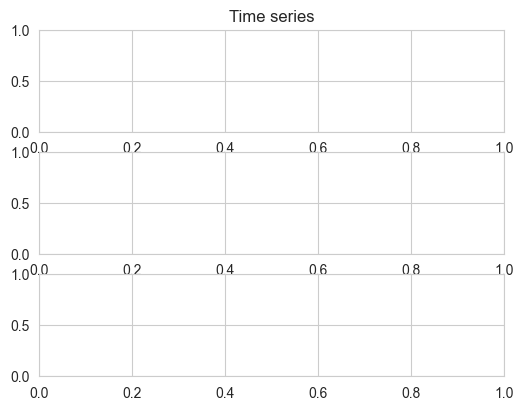

In [21]:
# Visualization
t = np.arange(0, 3+1/freq, 1/freq)
vis = Visualisation()
vis.plot_imfs(imfs=imfs, residue=res, t=t, include_residue=True)
# vis.plot_instant_freq(t, imfs=imfs)
vis.show()